## Laboratorio 3 - MLflow y Feast

- Sebastián Silva
- Melissa Pérez

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import mlflow
import feast

### Ejercicio 1 - Configuración del Entorno

In [2]:
def get_version(module, display_name):
    ver = getattr(module, "__version__", None)
    if ver is None:
        print(f"[ADVERTENCIA] No se pudo determinar la versión de {display_name} mediante __version__.")
        return "desconocida"
    return ver

all_ok = True

try:
    import mlflow as _mlflow
    print(f"MLflow está instalado. Versión: {get_version(_mlflow, 'MLflow')}")
except Exception as e:
    print(f"[ERROR] Al importar MLflow: {e}")
    all_ok = False

try:
    import feast as _feast
    print(f"Feast está instalado. Versión: {get_version(_feast, 'Feast')}")
except Exception as e:
    print(f"[ERROR] Al importar Feast: {e}")
    all_ok = False

MLflow está instalado. Versión: 3.1.4
Feast está instalado. Versión: 0.49.0


### Ejercicio 2 - Carga y Exploración de Datos

In [3]:
cal_housing = fetch_california_housing(as_frame=True)
df = cal_housing.frame.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
df.rename(columns={"MedInc": "median_income", 
                   "HouseAge": "house_age", 
                   "AveRooms": "average_rooms", 
                   "AveOccup": "average_occupants",
                   "Latitude": "latitude",
                   "Longitude": "longitude",
                   "MedHouseVal": "median_house_value"}, inplace=True)

In [6]:
df.head()

,median_income,house_age,average_rooms,AveBedrms,Population,average_occupants,latitude,longitude,median_house_value
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [7]:
print(f"Shape: {df.shape}")
print("\nTipos de datos:")
print(df.dtypes)

Shape: (20640, 9)

Tipos de datos:
median_income         float64
house_age             float64
average_rooms         float64
AveBedrms             float64
Population            float64
average_occupants     float64
latitude              float64
longitude             float64
median_house_value    float64
dtype: object


#### Análisis Exploratorio de Datos

In [8]:
print("Estadísticas descriptivas del dataset:")
display(df.describe().T)

Estadísticas descriptivas del dataset:


,count,mean,std,min,25%,50%,75%,max
median_income,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
house_age,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
average_rooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
average_occupants,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
median_house_value,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


In [9]:
# Estadísticas adicionales del target
print(f"\nEstadísticas de la variable target (median_house_value):")
print(f"Media: {df['median_house_value'].mean():.2f}")
print(f"Mediana: {df['median_house_value'].median():.2f}")
print(f"Desviación estándar: {df['median_house_value'].std():.2f}")
print(f"Mínimo: {df['median_house_value'].min():.2f}")
print(f"Máximo: {df['median_house_value'].max():.2f}")


Estadísticas de la variable target (median_house_value):
Media: 2.07
Mediana: 1.80
Desviación estándar: 1.15
Mínimo: 0.15
Máximo: 5.00


In [10]:
# Identificación de valores faltantes
missing_values = df.isnull().sum()
print("Valores faltantes por columna:")
print(missing_values)
print(f"\nTotal de valores faltantes: {missing_values.sum()}")

Valores faltantes por columna:
median_income         0
house_age             0
average_rooms         0
AveBedrms             0
Population            0
average_occupants     0
latitude              0
longitude             0
median_house_value    0
dtype: int64

Total de valores faltantes: 0


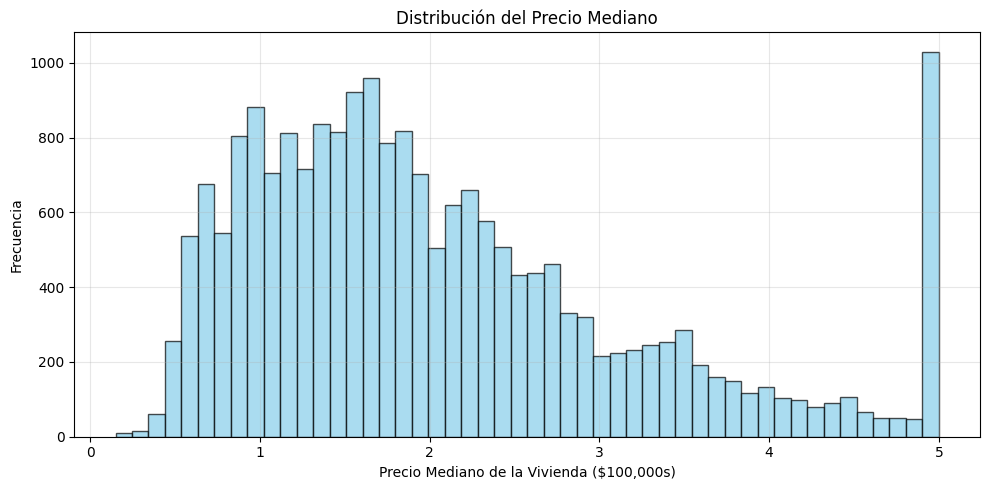

In [11]:
# Histograma - Distribución de la variable target
plt.figure(figsize=(10, 5))
plt.hist(df['median_house_value'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Precio Mediano de la Vivienda ($100,000s)')
plt.ylabel('Frecuencia')
plt.title('Distribución del Precio Mediano')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

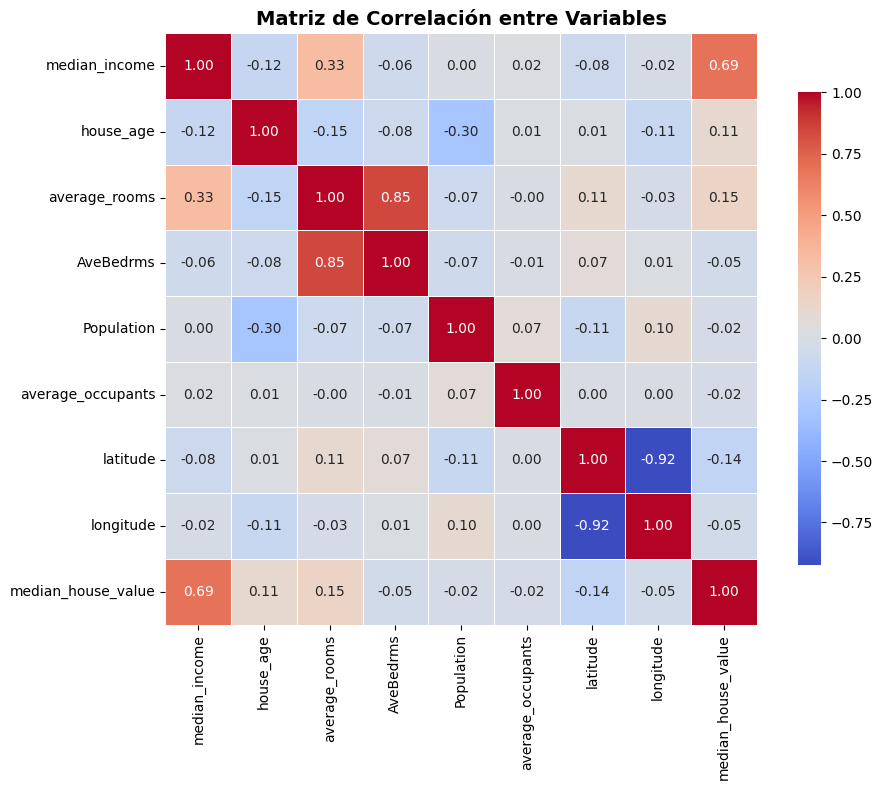

In [12]:
# Matriz de correlación entre variables
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación entre Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Ejercicio 3 - Preparación de Datos

In [13]:
# conjuntos de entrenamiento y prueba (80/20)
X = df.drop(columns=['median_house_value'])
y = df['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

In [14]:
# features derivadas en el conjunto de entrenamiento
X_train['rooms_per_household'] = X_train['average_rooms'] / X_train['average_occupants']
X_train['population_per_household'] = X_train['Population'] / X_train['AveBedrms']
X_train['bedrooms_per_room'] = X_train['AveBedrms'] / X_train['average_rooms']


In [15]:
# features en el conjunto de prueba
X_test['rooms_per_household'] = X_test['average_rooms'] / X_test['average_occupants']
X_test['population_per_household'] = X_test['Population'] / X_test['AveBedrms']
X_test['bedrooms_per_room'] = X_test['AveBedrms'] / X_test['average_rooms']

In [16]:
display(X_train[['rooms_per_household', 'population_per_household', 'bedrooms_per_room']].head())

,rooms_per_household,population_per_household,bedrooms_per_room
14196,1.359130,2285.326954,0.200576
8267,2.573820,1262.241423,0.232703
17445,2.073224,928.821752,0.174486
14265,1.002116,1371.634877,0.258269
2271,2.725400,770.580046,0.180940


# Ejercicio 4

In [17]:
mlflow.set_tracking_uri("file:./mlruns")

experiment_name = "california-housing-prediction"

try:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        experiment_id = mlflow.create_experiment(experiment_name)
        print(f"Experimento '{experiment_name}' creado con ID: {experiment_id}")
    else:
        print(f"Experimento '{experiment_name}' ya existe con ID: {experiment.experiment_id}")
        experiment_id = experiment.experiment_id
except Exception as e:
    print(f"Error al crear/obtener el experimento: {e}")
    experiment_id = None

if experiment_id:
    mlflow.set_experiment(experiment_name)
    print(f"Experimento activo configurado: {experiment_name}")
else:
    print("No se pudo configurar el experimento")


Experimento 'california-housing-prediction' ya existe con ID: 770921580831769508
Experimento activo configurado: california-housing-prediction


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [19]:
def train_and_log_model(model, model_name, X_train, X_test, y_train, y_test, **model_params):
    """
    Función para entrenar un modelo y registrar métricas en MLflow
    """
    with mlflow.start_run(run_name=model_name):
        # Loggear parámetros del modelo
        mlflow.log_params(model_params)
        
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Realizar predicciones
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Calcular métricas
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        
        # Loggear métricas
        mlflow.log_metric("rmse_train", rmse_train)
        mlflow.log_metric("rmse_test", rmse_test)
        mlflow.log_metric("mae_train", mae_train)
        mlflow.log_metric("mae_test", mae_test)
        mlflow.log_metric("r2_train", r2_train)
        mlflow.log_metric("r2_test", r2_test)
        
        # Loggear el modelo con signature e input example (usando DataFrame)
        mlflow.sklearn.log_model(
            model, 
            "model",
            input_example=X_test.iloc[:5],  # Usar DataFrame en lugar de .values
            signature=mlflow.models.infer_signature(X_test, y_pred_test)
        )
        
        print(f"\n=== {model_name} ===")
        print(f"RMSE Train: {rmse_train:.4f}, Test: {rmse_test:.4f}")
        print(f"MAE Train: {mae_train:.4f}, Test: {mae_test:.4f}")
        print(f"R² Train: {r2_train:.4f}, Test: {r2_test:.4f}")
        
        return model, {
            'rmse_train': rmse_train, 'rmse_test': rmse_test,
            'mae_train': mae_train, 'mae_test': mae_test,
            'r2_train': r2_train, 'r2_test': r2_test
        }


In [20]:
print("\n1. Entrenando Regresión Lineal...")
lr_model = LinearRegression()
lr_model, lr_metrics = train_and_log_model(
    lr_model, 
    "Linear_Regression",
    X_train, X_test, y_train, y_test
)


1. Entrenando Regresión Lineal...


2025/10/19 17:26:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



=== Linear_Regression ===
RMSE Train: 0.6729, Test: 0.6745
MAE Train: 0.4817, Test: 0.4848
R² Train: 0.6613, Test: 0.6528


In [21]:
print("\n2. Entrenando Random Forest Regressor...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model, rf_metrics = train_and_log_model(
    rf_model,
    "Random_Forest",
    X_train, X_test, y_train, y_test,
    n_estimators=100,
    random_state=42
)


2. Entrenando Random Forest Regressor...


2025/10/19 17:26:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



=== Random_Forest ===
RMSE Train: 0.1889, Test: 0.5051
MAE Train: 0.1225, Test: 0.3287
R² Train: 0.9733, Test: 0.8053


In [22]:
print("\n3. Entrenando Gradient Boosting Regressor...")
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model, gb_metrics = train_and_log_model(
    gb_model,
    "Gradient_Boosting",
    X_train, X_test, y_train, y_test,
    n_estimators=100,
    random_state=42
)


3. Entrenando Gradient Boosting Regressor...


2025/10/19 17:26:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



=== Gradient_Boosting ===
RMSE Train: 0.5045, Test: 0.5389
MAE Train: 0.3514, Test: 0.3682
R² Train: 0.8096, Test: 0.7784


In [23]:
print(f"{'Modelo':<20} {'RMSE':<8} {'MAE':<8} {'R²':<8}")
print("-" * 50)
print(f"{'Linear Regression':<20} {lr_metrics['rmse_test']:<8.4f} {lr_metrics['mae_test']:<8.4f} {lr_metrics['r2_test']:<8.4f}")
print(f"{'Random Forest':<20} {rf_metrics['rmse_test']:<8.4f} {rf_metrics['mae_test']:<8.4f} {rf_metrics['r2_test']:<8.4f}")
print(f"{'Gradient Boosting':<20} {gb_metrics['rmse_test']:<8.4f} {gb_metrics['mae_test']:<8.4f} {gb_metrics['r2_test']:<8.4f}")

Modelo               RMSE     MAE      R²      
--------------------------------------------------
Linear Regression    0.6745   0.4848   0.6528  
Random Forest        0.5051   0.3287   0.8053  
Gradient Boosting    0.5389   0.3682   0.7784  


In [24]:
# Registrar modelos en MLflow Model Registry
print("Registrando modelos en MLflow Model Registry...")

# Obtener el experimento actual
experiment = mlflow.get_experiment_by_name("california-housing-prediction")
experiment_id = experiment.experiment_id

# Buscar todos los runs del experimento
runs = mlflow.search_runs(experiment_ids=[experiment_id])

# Obtener los run IDs de cada modelo
lr_run = runs[runs['tags.mlflow.runName'] == 'Linear_Regression'].iloc[0]
rf_run = runs[runs['tags.mlflow.runName'] == 'Random_Forest'].iloc[0]
gb_run = runs[runs['tags.mlflow.runName'] == 'Gradient_Boosting'].iloc[0]

print(f"Run IDs encontrados:")
print(f"  Linear Regression: {lr_run['run_id']}")
print(f"  Random Forest: {rf_run['run_id']}")
print(f"  Gradient Boosting: {gb_run['run_id']}")

# Registrar modelos en el Model Registry
model_registry_name = "california_housing_models"

try:
    # Registrar Linear Regression
    lr_model_version = mlflow.register_model(
        model_uri=f"runs:/{lr_run['run_id']}/model",
        name=f"{model_registry_name}_linear_regression"
    )
    print(f"Linear Regression registrado como versión: {lr_model_version.version}")
    
    # Registrar Random Forest
    rf_model_version = mlflow.register_model(
        model_uri=f"runs:/{rf_run['run_id']}/model",
        name=f"{model_registry_name}_random_forest"
    )
    print(f"Random Forest registrado como versión: {rf_model_version.version}")
    
    # Registrar Gradient Boosting
    gb_model_version = mlflow.register_model(
        model_uri=f"runs:/{gb_run['run_id']}/model",
        name=f"{model_registry_name}_gradient_boosting"
    )
    print(f"Gradient Boosting registrado como versión: {gb_model_version.version}")
    
    print("\nTodos los modelos han sido registrados exitosamente en el Model Registry!")
    
except Exception as e:
    print(f"Error al registrar modelos: {e}")


Registered model 'california_housing_models_linear_regression' already exists. Creating a new version of this model...
2025/10/19 17:26:51 WARNING mlflow.tracking._model_registry.fluent: Run with id 9f462bdd144b49e28061d1f933304984 has no artifacts at artifact path 'model', registering model based on models:/m-ef2316cac5f54221b9f07a98c7845bb1 instead


Created version '4' of model 'california_housing_models_linear_regression'.
Registered model 'california_housing_models_random_forest' already exists. Creating a new version of this model...
2025/10/19 17:26:51 WARNING mlflow.tracking._model_registry.fluent: Run with id 12d4c808701244dbb4f94eaf8e19f5d4 has no artifacts at artifact path 'model', registering model based on models:/m-810ca035e55248e7820d78317dfc182a instead


Registrando modelos en MLflow Model Registry...
Run IDs encontrados:
  Linear Regression: 9f462bdd144b49e28061d1f933304984
  Random Forest: 12d4c808701244dbb4f94eaf8e19f5d4
  Gradient Boosting: f38de3ad865542358a201f1deb80365a
Linear Regression registrado como versión: 4
Random Forest registrado como versión: 4


Created version '4' of model 'california_housing_models_random_forest'.
Registered model 'california_housing_models_gradient_boosting' already exists. Creating a new version of this model...
2025/10/19 17:26:51 WARNING mlflow.tracking._model_registry.fluent: Run with id f38de3ad865542358a201f1deb80365a has no artifacts at artifact path 'model', registering model based on models:/m-46d6ceace4954dbd889b4579d8355613 instead


Gradient Boosting registrado como versión: 4

Todos los modelos han sido registrados exitosamente en el Model Registry!


Created version '4' of model 'california_housing_models_gradient_boosting'.


In [ ]:
print("Configurando Feast Feature Store...")

from feast import FeatureStore
store = FeatureStore(repo_path="./california_feature_store/feature_repo")
print("FeatureStore inicializado correctamente")

Configurando Feast Feature Store...
FeatureStore inicializado correctamente


/home/hsilv/miniconda3/envs/mlops_lab03/lib/python3.9/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "vector_enabled" in "SqliteOnlineStoreConfig" shadows an attribute in parent "VectorStoreConfig"
  warnings.warn(
/home/hsilv/miniconda3/envs/mlops_lab03/lib/python3.9/site-packages/feast/repo_config.py:268: DeprecationWarning: The serialization version 2 and below will be deprecated in the next release. Specifying `entity_key_serialization_version` to 3 is recommended.
  warnings.warn(


In [ ]:
print("Features disponibles en el Feature Store:")
feature_views = store.list_feature_views()
for fv in feature_views:
    print(f"  - {fv.name}")
    print(f"    Entidades: {fv.entities}")
    print(f"    Features: {[field.name for field in fv.schema]}")

Features disponibles en el Feature Store:
  - driver_hourly_stats_fresh
    Entidades: ['driver']
    Features: ['acc_rate', 'driver_id', 'avg_daily_trips', 'conv_rate']
  - driver_hourly_stats
    Entidades: ['driver']
    Features: ['acc_rate', 'driver_id', 'avg_daily_trips', 'conv_rate']
  - california_housing_features
    Entidades: ['house']
    Features: ['house_id', 'median_house_value', 'population', 'house_age', 'median_income', 'average_occupants', 'longitude', 'average_rooms', 'average_bedrooms', 'latitude']


In [ ]:
def retrieve_features_from_feast(store, entity_ids, feature_names=None):
    """
    Recuperar features desde Feast para un conjunto de entidades
    
    Args:
        store: FeatureStore de Feast
        entity_ids: Lista de house_id para los que queremos features
        feature_names: Lista de features específicas (opcional)
    
    Returns:
        DataFrame con las features recuperadas
    """
    print(f"Recuperando features para {len(entity_ids)} entidades...")
    
    try:
        entity_df = pd.DataFrame({
            "house_id": entity_ids,
            "event_timestamp": [pd.Timestamp.now()] * len(entity_ids)
        })
        
        if feature_names is None:
            feature_names = [
                "california_housing_features:median_income",
                "california_housing_features:house_age", 
                "california_housing_features:average_rooms",
                "california_housing_features:average_bedrooms",
                "california_housing_features:population",
                "california_housing_features:average_occupants",
                "california_housing_features:latitude",
                "california_housing_features:longitude"
            ]
        
        online_features = store.get_online_features(
            features=feature_names,
            entity_rows=entity_df.to_dict("records")
        ).to_df()
        
        print(f"Features recuperadas - Online: {online_features.shape}")
        
        return online_features
        
    except Exception as e:
        print(f"Error al recuperar features: {e}")
        return None

In [ ]:
def make_predictions_with_registry_model(features_df, model_name="california_housing_models_random_forest"):
    """
    Hacer predicciones usando un modelo del Model Registry
    
    Args:
        features_df: DataFrame con las features
        model_name: Nombre del modelo en el registry
    
    Returns:
        Array con las predicciones
    """
    print(f"Cargando modelo desde Model Registry: {model_name}")
    
    try:
        model = mlflow.sklearn.load_model(f"models:/{model_name}/1")
        print(f"Modelo cargado: {type(model).__name__}")
        
        feature_columns = [col for col in features_df.columns 
                          if col not in ["house_id", "event_timestamp", "created"]]
        
        X = features_df[feature_columns].copy()
        
        X["rooms_per_household"] = X["average_rooms"] / X["average_occupants"]
        X["population_per_household"] = X["population"] / X["average_bedrooms"]  
        X["bedrooms_per_room"] = X["average_bedrooms"] / X["average_rooms"]
        
        column_mapping = {
            "median_income": "median_income",
            "house_age": "house_age",
            "average_rooms": "average_rooms",
            "average_bedrooms": "AveBedrms",
            "population": "Population",
            "average_occupants": "average_occupants",
            "latitude": "latitude",
            "longitude": "longitude",
            "rooms_per_household": "rooms_per_household",
            "population_per_household": "population_per_household",
            "bedrooms_per_room": "bedrooms_per_room"
        }
        
        X = X.rename(columns=column_mapping)
        
        expected_features = [
            "median_income", "house_age", "average_rooms", "AveBedrms", "Population",
            "average_occupants", "latitude", "longitude", "rooms_per_household",
            "population_per_household", "bedrooms_per_room"
        ]
        
        X = X[expected_features]
        
        predictions = model.predict(X)
        
        print(f"Predicciones completadas: {len(predictions)} predicciones")
        print(f"Rango: ${predictions.min():.2f} - ${predictions.max():.2f}, Promedio: ${predictions.mean():.2f}")
        
        return predictions, feature_columns
        
    except Exception as e:
        print(f"Error al hacer predicciones: {e}")
        return None, None

In [31]:
entity_ids = list(range(10))
print(f"Entidades seleccionadas para predicción: {entity_ids}")

features_df = retrieve_features_from_feast(store, entity_ids)

if features_df is not None:
    print("\nFeatures recuperadas:")
    print(features_df.head())
    
    predictions, feature_columns = make_predictions_with_registry_model(features_df)
    
    if predictions is not None:
        results_df = features_df[["house_id"]].copy()
        
        for col in feature_columns:
            results_df[col] = features_df[col]
        
        results_df["predicted_house_value"] = predictions
        results_df["predicted_house_value_usd"] = predictions * 100000
        
        print("\nResultados de predicciones:")
        print(results_df[["house_id", "median_income", "house_age", "average_rooms", 
                         "predicted_house_value_usd"]].head())
        
        print(f"\nEstadísticas de predicciones:")
        print(f"Promedio: ${results_df['predicted_house_value_usd'].mean():,.2f}")
        print(f"Mediana: ${results_df['predicted_house_value_usd'].median():,.2f}")
        print(f"Mínimo: ${results_df['predicted_house_value_usd'].min():,.2f}")
        print(f"Máximo: ${results_df['predicted_house_value_usd'].max():,.2f}")

Entidades seleccionadas para predicción: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Recuperando features para 10 entidades...
Features recuperadas - Online: (10, 9)

Features recuperadas:
   house_id  population  average_rooms  longitude  average_bedrooms  \
0         0       322.0       6.984127    -122.23          1.023810   
1         1      2401.0       6.238137    -122.22          0.971880   
2         2       496.0       8.288136    -122.24          1.073446   
3         3       558.0       5.817352    -122.25          1.073059   
4         4       565.0       6.281853    -122.25          1.081081   

   house_age  average_occupants  median_income  latitude  
0       41.0           2.555556         8.3252     37.88  
1       21.0           2.109842         8.3014     37.86  
2       52.0           2.802260         7.2574     37.85  
3       52.0           2.547945         5.6431     37.85  
4       52.0           2.181467         3.8462     37.85  
Cargando modelo desde Model Registry: calif

/home/hsilv/miniconda3/envs/mlops_lab03/lib/python3.9/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Modelo cargado: RandomForestRegressor
Predicciones completadas: 10 predicciones
Rango: $2.09 - $4.23, Promedio: $3.05

Resultados de predicciones:
   house_id  median_income  house_age  average_rooms  \
0         0         8.3252       41.0       6.984127   
1         1         8.3014       21.0       6.238137   
2         2         7.2574       52.0       8.288136   
3         3         5.6431       52.0       5.817352   
4         4         3.8462       52.0       6.281853   

   predicted_house_value_usd  
0                  423350.26  
1                  389988.11  
2                  385052.14  
3                  329920.04  
4                  311339.00  

Estadísticas de predicciones:
Promedio: $304,990.65
Mediana: $287,083.00
Mínimo: $209,160.00
Máximo: $423,350.26


/home/hsilv/miniconda3/envs/mlops_lab03/lib/python3.9/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
